# Introduction to Astrometry - Exercises

### Dora Föhring, University of Hawaii Institute for Astronomy

Aim: To measure the position and uncertainty of a Near Earth Asteroid

## 0. Prerequisites

If you do not have `astroquery` installed, you will need to add it to your conda environment (from the command line):

    conda install -c astropy astroquery

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from astropy import wcs
from astroquery.gaia import Gaia
## make matplotlib appear in the notebook rather than in a new window
%matplotlib inline

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


### 0.1 Directory Set up & Display Image

In [2]:
datadir = 'PointSourcePhotometry_DF/'
objname  = '2016HO3'

In [3]:
def plotfits(imno):
    img = fits.open(datadir+objname+'_{0:02d}.fits'.format(imno))[0].data

    f = plt.figure(figsize=(10,12))
    im = plt.imshow(img, cmap='hot')
    im = plt.imshow(img[480:560, 460:540], cmap='hot')
    plt.clim(1800, 2800)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.savefig("figure{0}.png".format(imno))
    plt.show()

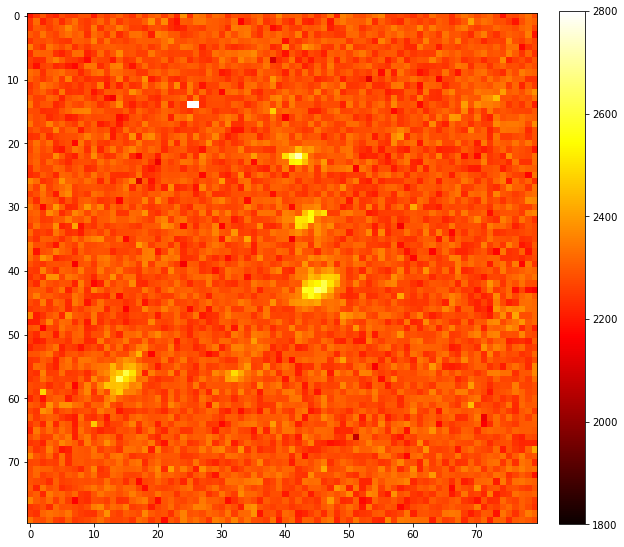

In [4]:
numb = 1 
plotfits(numb)

## 1. Centroiding on Images

Write a text file with image centers.
Write code to open each image and extract centroid position from previous exercise.
Save results in a text file.

In [5]:
centers = np.array([[502,501], [502,501]])
np.savetxt('centers.txt', centers, fmt='%i')
centers = np.loadtxt('centers.txt', dtype='int')

In [6]:
searchr = 5

### 1.1 Center of Mass

In [7]:
def cent_weight(n):
    """
    Assigns centroid weights
    """
    wghts=np.zeros((n),np.float)
    for i in range(n):
        wghts[i]=float(i-n/2)+0.5
    return wghts

def calc_CoM(psf, weights):
    """
    Finds Center of Mass of image
    """
    cent=np.zeros((2),np.float)
    temp=sum(sum(psf) - min(sum(psf) ))
    cent[1]=sum(( sum(psf) - min(sum(psf)) ) * weights)/temp
    cent[0]=sum(( sum(psf.T) - min(sum(psf.T)) ) *weights)/temp
    return cent

In [8]:
centlist = []
for i, center in enumerate(centers):
    image = fits.open(datadir+objname+'_{0:02d}.fits'.format(i+1))[0].data
    searchbox = image[center[0]-searchr : center[0]+searchr, center[1]-searchr : center[1]+searchr]
    boxlen = len(searchbox)
    weights = cent_weight(boxlen)
    cen_offset = calc_CoM(searchbox, weights)
    centlist.append(center + cen_offset)

In [9]:
print(centlist[0])

[ 502.05095604  501.91082726]


## 2. Identifying Stars in the Field

#### Ex 1. Write code to identify stars in the field. 

One way to do it would be:  
Create a new image using an mapping arc sinh that captures the full dynamic range effectively.  
Locate lower and upper bounds that should include only stars.  
Refine the parameters to optimize the extraction of stars from background.

In [36]:
no = 1
image = fits.open(datadir+objname+'_{0:02d}.fits'.format(no))[0].data

#### 1.a. Create a new image using an mapping arc sinh that captures the full dynamic range effectively. Consider Gaussian smoothing to get rid of inhomogineties in the image. 

In [11]:
## Some functions you may want to use
import skimage.exposure as skie
from scipy.ndimage import gaussian_filter

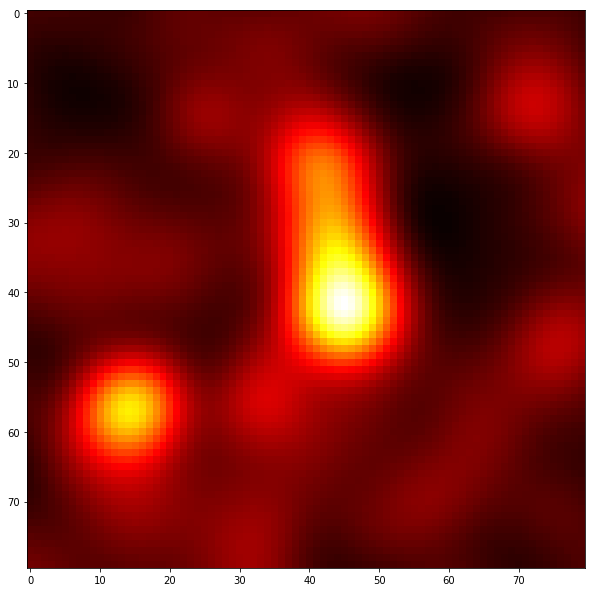

[ 10400   6888   9961  49398 586593 238266  45740  20911  12253   8134
   5770   4621   3697   3031   2539   2269   1979   1780   1622   1503
   1306   1251   1078   1010    903    832    715    667    596    542
    503    477    464    418    398    390    350    333    344    323
    324    275    307    253    286    263    256    250    238    226
    219    227    205    225    205    210    186    187    183    175
    189    174    188    162    160    173    182    161    170    139
    149    150    140    141    144    123    112    140    105    115
    111    129    104    112    109    109     92     94    112     84
    101     94     92     91     82     84     94     84     78     76
     79     71     75     64     79     56     72     82     63     76
     58     67     57     68     67     56     61     55     53     65
     63     46     46     66     44     57     61     53     44     49
     49     56     44     51     40     46     50     39     44     51
     3

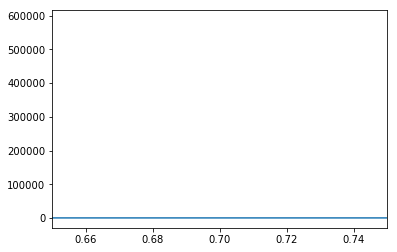

In [65]:
limg=np.arcsinh(image)
limg=limg/limg.max()
low=np.percentile(limg,25)
high=np.percentile(limg,99.5)
rescaled=skie.rescale_intensity(limg, in_range=(low,high))
#rescaled=image
smoothed_im=gaussian_filter(rescaled,(5,5), order=0)
f = plt.figure(figsize=(10,12))
im = plt.imshow(smoothed_im, cmap='hot')
im = plt.imshow(smoothed_im[480:560, 460:540], cmap='hot')
#plt.colorbar(smoothed_im[480:560, 460:540])
#plt.savefig("figure{0}.png".format(imno))
plt.show()

hist,bins=skie.histogram(smoothed_im)
plt.plot(bins,hist)
plt.xlim(0.65,0.75)
print(hist, bins)

#### 1.b. Create a new image that is scaled between the lower and upper limits for displaying the star map.  
Search the arcsinh-stretched original image for local maxima and catalog those brighter than a threshold that is adjusted based on the image.

In [31]:
## Consider using
import skimage.morphology as morph

In [75]:
maxima=morph.local_maxima(smoothed_im)#[480:560, 460:540])
x1, y1 = np.where(maxima.T == True)
v=limg[(y1,x1)]
lim=0.7
pos=np.where(limg[(y1,x1)]>=lim)[0]
x2=x1[pos]
y2=y1[pos]

Plot image with identified stars and target

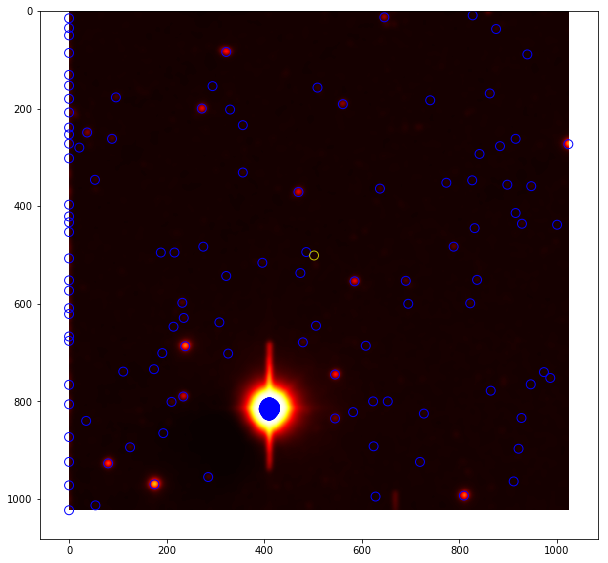

In [76]:
f = plt.figure(figsize=(10,12))
plt.imshow(smoothed_im, cmap='hot')
#plt.colorbar(fraction=0.046, pad=0.04)
plt.scatter(x2, y2, s=80, facecolors='none', edgecolors='b')
plt.scatter(502.01468185, 501.00082137, s=80, facecolors='none', edgecolors='y' )
plt.show()

## 3. Converting pixel coordinates to WCS

In [73]:
def load_wcs_from_file(filename, xx, yy):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)

    # Parse the WCS keywords in the primary HDU
    w = wcs.WCS(hdulist[0].header)

    # Print out the "name" of the WCS, as defined in the FITS header
    print(w.wcs.name)

    # Print out all of the settings that were parsed from the header
    w.wcs.print_contents()

    # Coordinates of interest.
    # Note we've silently assumed a NAXIS=2 image here
    targcrd = np.array([centlist[0]], np.float_)
    
    starscrd = np.array([xx, yy], np.float_)

    # Convert pixel coordinates to world coordinates
    # The second argument is "origin".
    world = w.wcs_pix2world(starscrd.T, 0)

    return w, world

Find position of Asteroid in WCS

In [77]:
wparams, scoords = load_wcs_from_file(datadir+objname+'_{0:02d}.fits'.format(1), x2, y2)

In [83]:
print(wparams,scoords)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 193.35149999999999  33.869281000000001  
CRPIX : 445.0  564.0  
CD1_1 CD1_2  : -0.0001222222  5.3897533e-11  
CD2_1 CD2_2  : -2.2144648999999999e-11  0.00012222222  
NAXIS : 1024  1024 [[ 193.41680571   33.80228606]
 [ 193.41680758   33.8047305 ]
 [ 193.41680898   33.80656383]
 ..., 
 [ 193.27169581   33.89235526]
 [ 193.26967123   33.85397618]
 [ 193.26630634   33.83380725]]


In [79]:
wparams, tcoords = load_wcs_from_file(datadir+objname+'_{0:02d}.fits'.format(1), np.array([centlist[0][0]]), np.array([centlist[0][1]]))

In [80]:
print(tcoords)

[[ 193.34295562   33.86181425]]


## 3. Matching

### 3.1 Get astrometric catalog

In [81]:
job = Gaia.launch_job_async("SELECT * \
FROM gaiadr1.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS', 193.34, 33.86, 0.08))=1;" \
, dump_to_file=True)

print (job)

Launched query: 'SELECT * FROM gaiadr1.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr1.gaia_source.ra,gaiadr1.gaia_source.dec),CIRCLE('ICRS', 193.34, 33.86, 0.08))=1;'
Retrieving async. results...
Jobid: 1516810346973O
Phase: None
Owner: None
Output file: async_20180124101227.vot
Results: None


In [82]:
r = job.get_results()
print (r['source_id'], r['ra'], r['dec'])
print(type(r['ra']))

     source_id     
-------------------
1515770241672792704
1515751378176545408
1515769623197411456
1515769378384464768
1515751236442583296
1515751270802228736
1515769206585764480
1515751305162058752
1515764258783437696
1515751373881536256
                ...
1515769240945469952
1515750995924397696
1515750995924397824
1515763880826316416
1515762850034149376
1515757936591587328
1515762987473110656
1515757558634354304
1515756325978649728
1515762678235367040
1515769309667939712
Length = 36 rows         ra        
       deg        
------------------
193.31962507821265
193.34217139504767
193.35493968928526
193.38327685694409
193.38505967616862
193.33814860467297
193.35475877015173
193.35034321839012
193.26059009959198
193.34280810593697
               ...
193.36581521621554
193.35734586149439
193.25293663775915
193.26330158841628
193.40686364810929
193.28605697007046
193.40878840515927
  193.432503454244
193.29670644446338
193.39456770646817
Length = 36 rows        dec        
       deg 

## 3.2 Perform Match

Convert Gaia WCS coordinates to pixels

In [87]:
ra  = np.array(r['ra'])
dec = np.array(r['dec'])
print(ra, dec)
#w = wparams('image.fits')

xpix, ypix = wparams.wcs_world2pix(ra,dec,0)
print(xpix, ypix)

[ 193.31962508  193.3421714   193.35493969  193.38327686  193.38505968
  193.3381486   193.35475877  193.35034322  193.2605901   193.34280811
  193.34501843  193.42831836  193.37767251  193.39021532  193.39067642
  193.3302851   193.36723905  193.33922769  193.2990793   193.35608775
  193.3147467   193.32383537  193.27500814  193.30631427  193.30939266
  193.36500163  193.36581522  193.35734586  193.25293664  193.26330159
  193.40686365  193.28605697  193.40878841  193.43250345  193.29670644
  193.39456771] [ 33.92006069  33.83026268  33.93622313  33.92374324  33.83176866
  33.80429056  33.89007982  33.82641416  33.88169951  33.83067515
  33.89825543  33.88230488  33.81757199  33.89102541  33.90360253
  33.80901954  33.78414525  33.87493509  33.8077218   33.85265207
  33.79345639  33.874842    33.84061392  33.9284367   33.86632339
  33.90668256  33.79433383  33.79348664  33.88607805  33.82194289
  33.91623737  33.85115765  33.89738946  33.8386884   33.81197806
  33.90491998]
[  660.412

Plot Gaia stars over identified stars in image

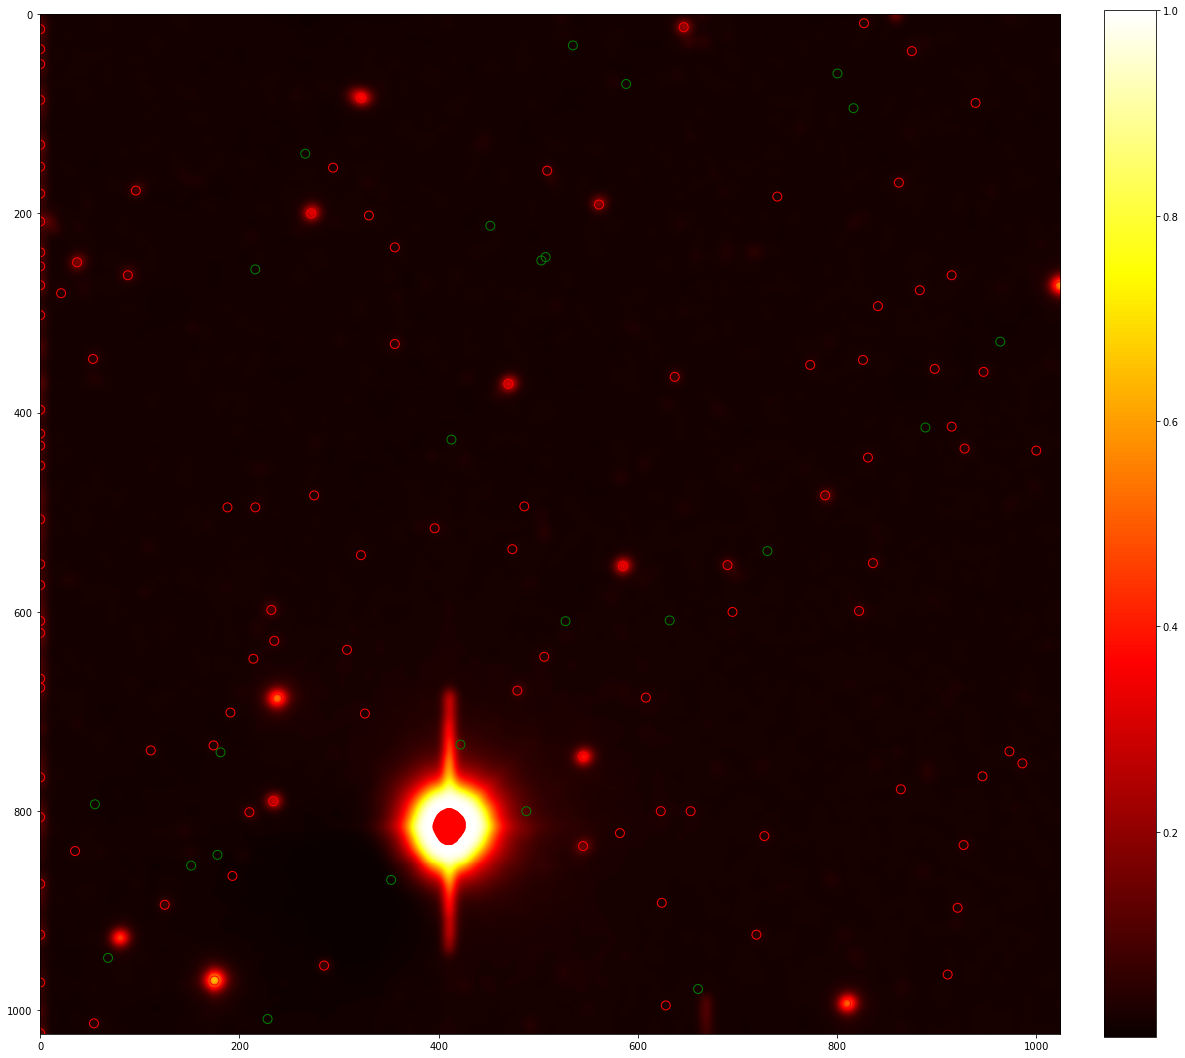

In [90]:
f = plt.figure(figsize=(20,22))
plt.imshow(smoothed_im, cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.scatter(x2, y2, s=80, facecolors='none', edgecolors='r')
plt.scatter(xpix, ypix, s=80, facecolors='none', edgecolors='g')
#plt.scatter(xpix[17], ypix[17], s=80, facecolors='none', edgecolors='y')
plt.imshow(smoothed_im, cmap='hot')
plt.show()

#### Ex. 2 Find the amount of shift needed. 

Match catalogue stars to identified stars and measure amount of shift needed to overlay FoV stars to catalogue.

E.g. Find closest star to one of the Gaia stars near the center of image. Find magnitude of shift. Shift all other Gaia stars and see whether resulting difference is small.

470 371
412.82718347 426.945805251
57.17281653 -55.9458052507


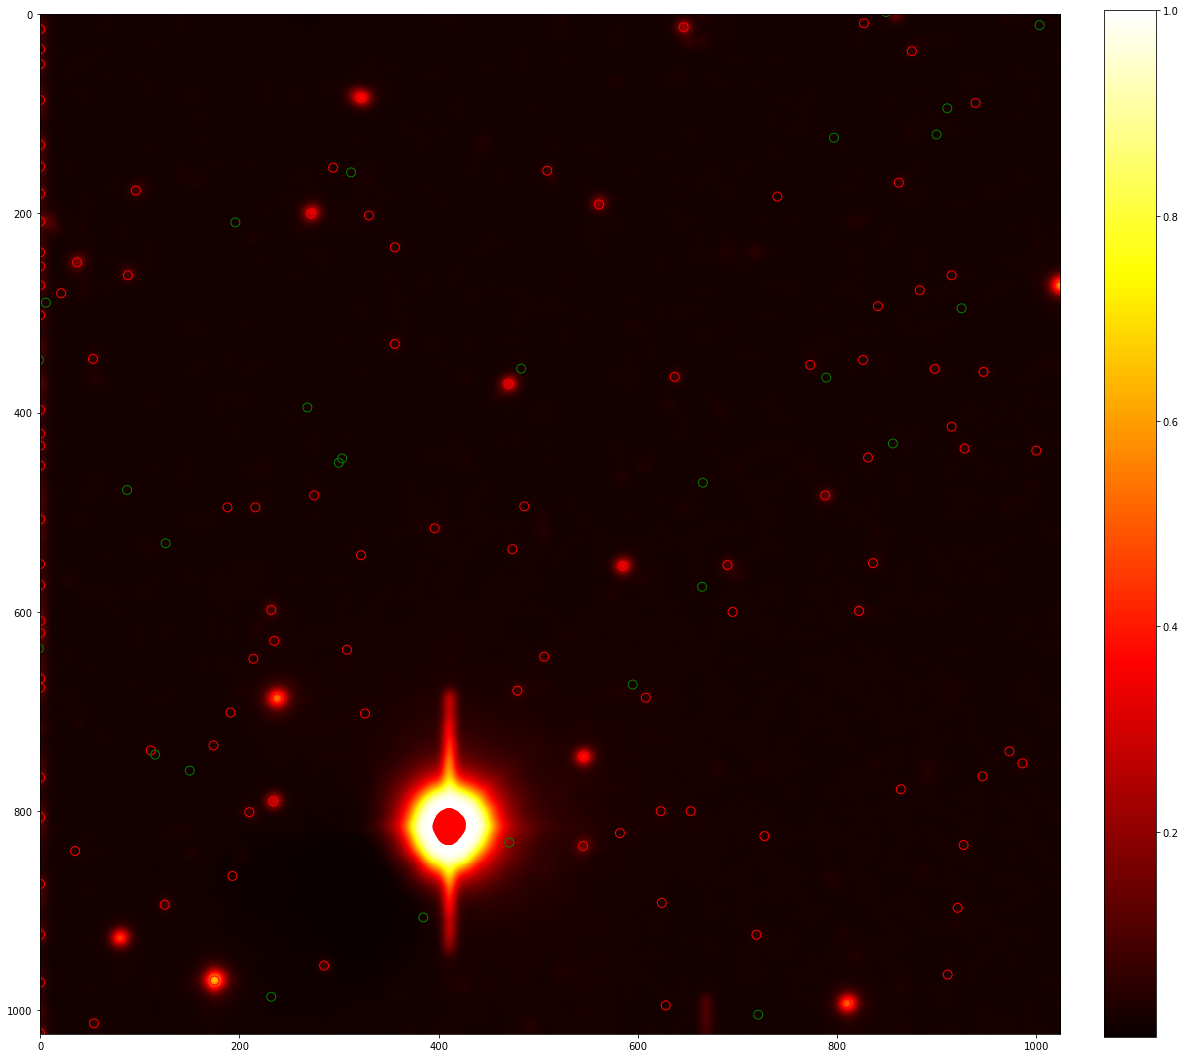

In [107]:
for x,y in zip(x2,y2):
    if x>400 and x<550 and y<400 and y>300:
        x_targ=x
        y_targ=y
        print(x,y)
        
for x_cat, y_cat in zip(xpix,ypix):
    if x_cat>400 and x_cat<450 and y_cat>400 and y_cat<500:
        x_gaia=x_cat
        y_gaia=y_cat
        print(x_cat,y_cat)
        
xshift=x_targ-x_gaia
yshift=y_targ-y_gaia
print(xshift,yshift)

count=0
yshifted=np.zeros_like(ypix)
xshifted=np.zeros_like(xpix)
for x_cat, y_cat in zip(xpix,ypix):
    yshifted[count]=x_cat-xshift
    xshifted[count]=y_cat-yshift
    count=count+1
    
f = plt.figure(figsize=(20,22))
plt.imshow(smoothed_im, cmap='hot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.scatter(x2, y2, s=80, facecolors='none', edgecolors='r')
plt.scatter(xshifted, yshifted, s=80, facecolors='none', edgecolors='g')
#plt.scatter(xpix[17], ypix[17], s=80, facecolors='none', edgecolors='y')
plt.imshow(smoothed_im, cmap='hot')
plt.show()

Shift

In [108]:
targshifted = centlist[0] + np.array([xshift, yshift])
print(centlist)

[array([ 502.05095604,  501.91082726]), array([ 499.91239534,  503.61546732])]


Convert shifted coordinate into WCS

In [109]:
wparams, tscoords = load_wcs_from_file(datadir+objname+'_{0:02d}.fits'.format(1), np.array([targshifted[0][0][0]]), np.array([targshifted[0][0][1]]))

IndexError: invalid index to scalar variable.

## Bonus questions

#### B1. Write a function for centroiding using Gaussian PSF fitting.

#### B2. The stars are actually slightly trailed. How would you fit trailed stars?